In [1]:
from src.utils import *
from os.path import join, isfile, exists, abspath
import mdtraj as md
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from Bio.PDB import PDBParser

# enable Open MPI Cuda awareness (on Linux systems)
!export GMX_OCL_NO_PLATFORMS=1
!export GMX_OCL_PLATFORM=0
!export GMX_OCL_DEVICE=0
!export OMPI_MCA_opal_cuda_support=true

# set up variables for directories
DATA = './data/'
RAW = join(DATA, 'raw')
PROCESSED = join(DATA, 'processed')
FINAL = join(DATA, 'final')
PARAMS = join(DATA, 'params')
FIGURES = './figures/'

#### Print out the environment

In [2]:
import subprocess
result = subprocess.run(['conda', 'env', 'export', '--no-builds'], stdout=subprocess.PIPE)
conda_env = '\n'.join(result.stdout.decode().strip().split('\n')[:-1])
display(print(conda_env))

name: gromacs
channels:
  - conda-forge
dependencies:
  - _libgcc_mutex=0.1
  - _openmp_mutex=4.5
  - alsa-lib=1.2.13
  - anyio=4.8.0
  - argon2-cffi=23.1.0
  - argon2-cffi-bindings=21.2.0
  - arrow=1.3.0
  - asttokens=3.0.0
  - async-lru=2.0.4
  - attrs=24.3.0
  - babel=2.16.0
  - beautifulsoup4=4.12.3
  - binutils=2.43
  - binutils_impl_linux-64=2.43
  - binutils_linux-64=2.43
  - biopandas=0.5.1
  - biopython=1.85
  - bleach=6.2.0
  - bleach-with-css=6.2.0
  - blosc=1.21.6
  - brotli=1.1.0
  - brotli-bin=1.1.0
  - brotli-python=1.1.0
  - bzip2=1.0.8
  - c-ares=1.34.4
  - c-blosc2=2.15.2
  - c-compiler=1.9.0
  - ca-certificates=2024.12.14
  - cached-property=1.5.2
  - cached_property=1.5.2
  - cairo=1.18.2
  - certifi=2024.12.14
  - cffi=1.17.1
  - charset-normalizer=3.4.1
  - clinfo=3.0.21.02.21
  - cmake=3.31.4
  - colorama=0.4.6
  - comm=0.2.2
  - compilers=1.9.0
  - contourpy=1.3.1
  - cxx-compiler=1.9.0
  - cycler=0.12.1
  - cyrus-sasl=2.1.27
  - dbus=1.13.6
  - debugpy=1.8.12
 

None

# MD simulation of a designed protein to elucidate stability

## Set simulation parameters

In [3]:
prot = '2k6m'
pos_ion = 'NA'
neg_ion = 'CL'
nacl_conc = 0.15 # NaCl concentration in M
water_model = 'tip3p'
force_field = 'charmm27'
temperatures = list(range(300, 370, 10))

## Clean the input structure
Remove hydrogens, alernate positions, HETATOMS etc.

In [4]:
pdb_file = join(RAW, f'{prot}.pdb')
pdb_file_clean = join(PROCESSED,  f'{prot}_clean.pdb')
!grep MISSING $pdb_file

In [5]:
# load structure
structure = PDBParser().get_structure(id=prot, 
                                      file=pdb_file)

# save the cleaned structure
io = PDBIO()
io.set_structure(structure)
io.save(pdb_file_clean, CleanSelect())

#### Make structure force-field compliant and generate a topology

In [6]:
structure_file = join(PROCESSED,  f'{prot}_processed.gro')
topol_file = join(PROCESSED, f'{prot}_topol.top')
posre_file = abspath(join(PROCESSED, f'{prot}_posre.itp')) # absolute path info is stored in topol.top
!gmx pdb2gmx -f $pdb_file_clean -o $structure_file -i $posre_file -p $topol_file -water $water_model -ff $force_field

cat: write error: Broken pipe
               :-) GROMACS - gmx pdb2gmx, 2022.4-conda_forge (-:

Executable:   /home/martin/miniforge3/envs/gromacs/bin.AVX2_256/gmx
Data prefix:  /home/martin/miniforge3/envs/gromacs
Working dir:  /data/10_projects/md_solutions
Command line:
  gmx pdb2gmx -f ./data/processed/2k6m_clean.pdb -o ./data/processed/2k6m_processed.gro -i /data/10_projects/md_solutions/data/processed/2k6m_posre.itp -p ./data/processed/2k6m_topol.top -water tip3p -ff charmm27

Using the Charmm27 force field in directory charmm27.ff

going to rename charmm27.ff/aminoacids.r2b
Opening force field file /home/martin/miniforge3/envs/gromacs/share/gromacs/top/charmm27.ff/aminoacids.r2b

going to rename charmm27.ff/rna.r2b
Opening force field file /home/martin/miniforge3/envs/gromacs/share/gromacs/top/charmm27.ff/rna.r2b
Reading ./data/processed/2k6m_clean.pdb...
Read '', 542 atoms

Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.

There are 1 chai

#### Define a simulation box

In [7]:
box_file = join(PROCESSED,  f'{prot}_newbox.gro')
!gmx editconf -f $structure_file -o $box_file -c -d 1.0 -bt dodecahedron

               :-) GROMACS - gmx editconf, 2022.4-conda_forge (-:

Executable:   /home/martin/miniforge3/envs/gromacs/bin.AVX2_256/gmx
Data prefix:  /home/martin/miniforge3/envs/gromacs
Working dir:  /data/10_projects/md_solutions
Command line:
  gmx editconf -f ./data/processed/2k6m_processed.gro -o ./data/processed/2k6m_newbox.gro -c -d 1.0 -bt dodecahedron

Note that major changes are planned in future for editconf, to improve usability and utility.
Read 1102 atoms
Volume: 41.7966 nm^3, corresponds to roughly 18800 electrons
No velocities found
    system size :  4.295  3.712  2.622 (nm)
    diameter    :  4.359               (nm)
    center      :  0.020 -0.041 -0.013 (nm)
    box vectors :  4.295  3.711  2.622 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :  41.80               (nm^3)
    shift       :  4.749  4.811  2.262 (nm)
new center      :  4.769  4.769  2.248 (nm)
new box vectors :  6.359  6.359  6.359 (nm)
new box angles  :  60.00  60.00  90.00 (deg

#### Fill box with water

In [8]:
solv_file = join(PROCESSED,  f'{prot}_solv.gro')
!gmx solvate -cp $box_file -o $solv_file -cs spc216.gro -p $topol_file

cat: write error: Broken pipe
               :-) GROMACS - gmx solvate, 2022.4-conda_forge (-:

Executable:   /home/martin/miniforge3/envs/gromacs/bin.AVX2_256/gmx
Data prefix:  /home/martin/miniforge3/envs/gromacs
Working dir:  /data/10_projects/md_solutions
Command line:
  gmx solvate -cp ./data/processed/2k6m_newbox.gro -o ./data/processed/2k6m_solv.gro -cs spc216.gro -p ./data/processed/2k6m_topol.top

Reading solute configuration
Reading solvent configuration

Initialising inter-atomic distances...

         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.

NOTE: From version 5.0 gmx solvate uses the Van d

#### Add ions to make protein happy

In [9]:
ions_tpr_file = join(PROCESSED,  f'{prot}_ions.tpr')
ions_mdp_file = join(PROCESSED,  f'{prot}_ions.mdp')
mdout_file = join(PROCESSED,  f'{prot}_mdp.mdp')

!touch $ions_mdp_file
!gmx grompp -f $ions_mdp_file -c $solv_file -p $topol_file -o $ions_tpr_file -po $mdout_file

cat: write error: Broken pipe
                :-) GROMACS - gmx grompp, 2022.4-conda_forge (-:

Executable:   /home/martin/miniforge3/envs/gromacs/bin.AVX2_256/gmx
Data prefix:  /home/martin/miniforge3/envs/gromacs
Working dir:  /data/10_projects/md_solutions
Command line:
  gmx grompp -f ./data/processed/2k6m_ions.mdp -c ./data/processed/2k6m_solv.gro -p ./data/processed/2k6m_topol.top -o ./data/processed/2k6m_ions.tpr -po ./data/processed/2k6m_mdp.mdp


NOTE 1 [file ./data/processed/2k6m_ions.mdp]:
  For a correct single-point energy evaluation with nsteps = 0, use
  continuation = yes to avoid constraining the input coordinates.

Setting the LD random seed to -674874492

Generated 20503 of the 20503 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 17396 of the 20503 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_S'

Excluding 2 bonded neighbours molecule type 'SOL'

NOTE 2 [file 2k6m_topol.top, line 10552]:
 

In [10]:
solv_ions_file = join(PROCESSED,  f'{prot}_solv_ions.gro')
!printf "SOL\n" | gmx genion -s $ions_tpr_file -o $solv_ions_file -conc $nacl_conc -p \
$topol_file -pname $pos_ion -nname $neg_ion -neutral

cat: write error: Broken pipe
                :-) GROMACS - gmx genion, 2022.4-conda_forge (-:

Executable:   /home/martin/miniforge3/envs/gromacs/bin.AVX2_256/gmx
Data prefix:  /home/martin/miniforge3/envs/gromacs
Working dir:  /data/10_projects/md_solutions
Command line:
  gmx genion -s ./data/processed/2k6m_ions.tpr -o ./data/processed/2k6m_solv_ions.gro -conc 0.15 -p ./data/processed/2k6m_topol.top -pname NA -nname CL -neutral

Reading file ./data/processed/2k6m_ions.tpr, VERSION 2022.4-conda_forge (single precision)
Reading file ./data/processed/2k6m_ions.tpr, VERSION 2022.4-conda_forge (single precision)
Will try to add 18 NA ions and 16 CL ions.
Select a continuous group of solvent molecules
Group     0 (         System) has 17932 elements
Group     1 (        Protein) has  1102 elements
Group     2 (      Protein-H) has   542 elements
Group     3 (        C-alpha) has    67 elements
Group     4 (       Backbone) has   201 elements
Group     5 (      MainChain) has   267 element

#### Minimize the structure

In [11]:
run_file = join(RAW,  'emin-charmm.mdp')
default_filename = join(PROCESSED, f'{prot}_em')
em_tpr_file = join(PROCESSED, f'{prot}_em.tpr')
!gmx grompp -f $run_file -c $solv_ions_file -p $topol_file -o $em_tpr_file -po $mdout_file
!gmx mdrun -v -deffnm $default_filename -s $em_tpr_file

cat: write error: Broken pipe
                :-) GROMACS - gmx grompp, 2022.4-conda_forge (-:

Executable:   /home/martin/miniforge3/envs/gromacs/bin.AVX2_256/gmx
Data prefix:  /home/martin/miniforge3/envs/gromacs
Working dir:  /data/10_projects/md_solutions
Command line:
  gmx grompp -f ./data/raw/emin-charmm.mdp -c ./data/processed/2k6m_solv_ions.gro -p ./data/processed/2k6m_topol.top -o ./data/processed/2k6m_em.tpr -po ./data/processed/2k6m_mdp.mdp

Ignoring obsolete mdp entry 'title'
Setting the LD random seed to -157352201

Generated 20503 of the 20503 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 17396 of the 20503 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_S'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bonded neighbours

#### Was minimization successful?

cat: write error: Broken pipe
                :-) GROMACS - gmx energy, 2022.4-conda_forge (-:

Executable:   /home/martin/miniforge3/envs/gromacs/bin.AVX2_256/gmx
Data prefix:  /home/martin/miniforge3/envs/gromacs
Working dir:  /data/10_projects/md_solutions
Command line:
  gmx energy -f ./data/processed/2k6m_em.edr -o ./data/final/2k6m_min_potential.xvg -xvg none

Opened ./data/processed/2k6m_em.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Potential       12  Pressure      
 13  Constr.-rmsd    14  Vir-XX          15  Vir-XY          16  Vir-XZ        
 17 

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_68543/1805393426.py:6: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(min_potential_file, sep='\s+', header=None, names=['time','energy'])


<Axes: xlabel='time'>

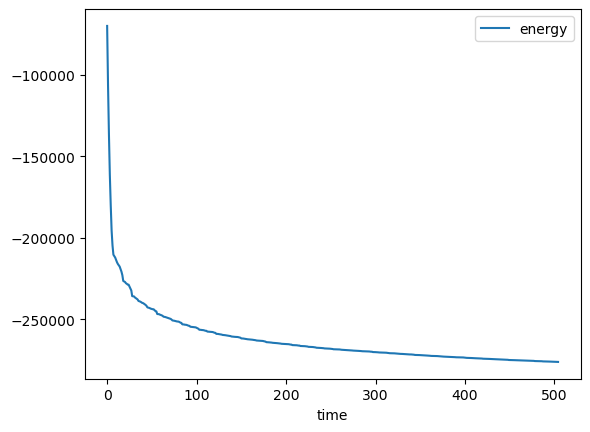

In [12]:
em_edr_file = join(PROCESSED, f'{prot}_em.edr')

min_potential_file = join(FINAL, f'{prot}_min_potential.xvg')

!printf "Potential\n0\n" | gmx energy -f $em_edr_file -o $min_potential_file -xvg none
df = pd.read_csv(min_potential_file, sep='\s+', header=None, names=['time','energy'])
df.plot('time')

## Loop through tempuratures and carry out simulation
The contact frequency analysis described in (doi: 10.1093/bioinformatics/btab538) reqires two trajectories to compare. In the article these are trajectories from two different variants (differing by one mutation). For this assignment I only have one variant. So the trajectories I choose to compare are instead ones made with the same protien, but at different temperatures. However, arbitrarily picking a temperature is not ideal. I therefore go through and simulate several temperatures. I want to find a high temperature at which there is significant movement in the protein, without it unfolding.

The original article uses a 400 ns MD simulation and carry out the analysis on the last 200 ns. Due to limited compute I am restricted to doing one 10th of that. So 40 ns and analyzing the last 20 ns. This choice is expected to make the analysis less precise and more noisy.

In [13]:
%%time

for temp in temperatures:
    # quilibrate temperature
    run_file = join(PARAMS,  f'nvt-charmm_{temp}k.mdp')
    em_gro_file = join(PROCESSED, f'{prot}_em.gro')
    nvt_tpr_file = join(PROCESSED, f'{prot}_{temp}k_nvt.tpr')
    default_filename = join(PROCESSED, f'{prot}_{temp}k_nvt')
    
    if exists(nvt_tpr_file):
        continue

    !gmx grompp -f $run_file -c $em_gro_file -r $em_gro_file -p $topol_file -o $nvt_tpr_file -po $mdout_file
    !gmx mdrun -ntmpi 1 -v -deffnm $default_filename -s $nvt_tpr_file
    
    # was temperature equilibration successful?
    nvt_edr_file = join(PROCESSED, f'{prot}_{temp}k_nvt.edr')
    temperature_file = join(FINAL, f'{prot}_{temp}k_temperature.xvg')

    !echo "Temperature" | gmx energy -f $nvt_edr_file -o $temperature_file -xvg none
    
    # equilibrate pressure
    run_file = join(PARAMS,  f'npt-charmm_{temp}k.mdp')
    nvt_gro_file = join(PROCESSED, f'{prot}_{temp}k_nvt.gro') 
    nvt_cpt_file = join(PROCESSED, f'{prot}_{temp}k_nvt.cpt')
    npt_tpr_file = join(PROCESSED, f'{prot}_{temp}k_npt.tpr')
    default_filename = join(PROCESSED, f'{prot}_{temp}k_npt')

    !gmx grompp -f $run_file -c $nvt_gro_file -r $nvt_gro_file -t $nvt_cpt_file -p $topol_file -o $npt_tpr_file -po $mdout_file
    !gmx mdrun -ntmpi 1 -v -deffnm $default_filename
    
    # was pressure equilibration successful?
    npt_edr_file = join(PROCESSED, f'{prot}_{temp}k_npt.edr')
    pressure_file = join(FINAL, f'{prot}_{temp}k_pressure.xvg')
    density_file = join(FINAL, f'{prot}_{temp}k_density.xvg')
    
    !echo "Pressure" | gmx energy -f $npt_edr_file -o $pressure_file -xvg none
    !echo "Density" | gmx energy -f $npt_edr_file -o $density_file -xvg none
    
    # carry out the big MD run
    run_file = join(PARAMS,  f'md-charmm_{temp}k.mdp')
    npt_gro_file = join(PROCESSED, f'{prot}_{temp}k_npt.gro') 
    npt_cpt_file = join(PROCESSED, f'{prot}_{temp}k_npt.cpt')
    md_tpr_file = join(PROCESSED, f'{prot}_{temp}k_md.tpr')
    default_filename = join(PROCESSED, f'{prot}_{temp}k_md')

    !gmx grompp -f $run_file -c $npt_gro_file -t $npt_cpt_file -p $topol_file -o $md_tpr_file -po $mdout_file
    !gmx mdrun -ntmpi 1 -v -deffnm $default_filename
    
    # center the protein
    md_xtc_file = join(PROCESSED, f'{prot}_{temp}k_md.xtc')
    md_xtc_center_file = join(PROCESSED, f'{prot}_{temp}k_md_center.xtc')
    mindist_file = join(FINAL, f'{prot}_{temp}k_mindist.xvg')

    !printf "1\n1\n" | gmx trjconv -s $md_tpr_file -f $md_xtc_file -o $md_xtc_center_file -center -pbc mol
    !printf "1\n" | gmx mindist -s $md_tpr_file -f $md_xtc_center_file -pi -od $mindist_file
    
    # RMSD for entire protein over time
    rmsd_time_file = join(FINAL, f'{prot}_{temp}k_rmsd_time.xvg')

    !printf "4\n1\n" | gmx rms -s $md_tpr_file -f $md_xtc_center_file -o $rmsd_time_file -tu ns -xvg none
    
    # get the root mean square fluctuation (RMSF) of the residues
    rmsf_chain_file = join(FINAL, f'{prot}_{temp}k_rmsf_chain.xvg')

    !printf "4\n1\n" | gmx rmsf -s $md_tpr_file -f $md_xtc_center_file -o $rmsf_chain_file -res -xvg none -b 20000
    
    # radius of gyration over time
    gyration_file = join(FINAL, f'{prot}_{temp}k_gyration.xvg')

    !echo "1" | gmx gyrate -s $md_tpr_file -f $md_xtc_center_file -o $gyration_file -xvg none
    
    # simulation data
    md_edr_file = join(PROCESSED, f'{prot}_{temp}k_md.edr')
    potential_file = join(FINAL, f'{prot}_{temp}k_potential.xvg')

    !echo "12\n0\n" | gmx energy -f $md_edr_file -o $potential_file -xvg none
    
    # output multiframe PDB file from trajectory
    multiframe_pdb_file = join(FINAL, f'{prot}_{temp}k.pdb') 
    !printf "1\n1\n" | gmx trjconv -f $md_xtc_center_file -s $npt_gro_file -o $multiframe_pdb_file -b 20000

cat: write error: Broken pipe
                :-) GROMACS - gmx grompp, 2022.4-conda_forge (-:

Executable:   /home/martin/miniforge3/envs/gromacs/bin.AVX2_256/gmx
Data prefix:  /home/martin/miniforge3/envs/gromacs
Working dir:  /data/10_projects/md_solutions
Command line:
  gmx grompp -f ./data/params/nvt-charmm_300k.mdp -c ./data/processed/2k6m_em.gro -r ./data/processed/2k6m_em.gro -p ./data/processed/2k6m_topol.top -o ./data/processed/2k6m_300k_nvt.tpr -po ./data/processed/2k6m_mdp.mdp

Ignoring obsolete mdp entry 'title'
Setting the LD random seed to -312615185

Generated 20503 of the 20503 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 17396 of the 20503 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_S'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constra

# Data analysis
Take a look at the MD run outputs. First I look at whether the MD run equilibration looks ok.

In [ ]:
# set up colors
cmap, norm = get_cmap(data=None, vmin=temperatures[0], vmax=temperatures[-1], cmap='viridis')

In [ ]:
# Plot temp and pressure equilibration
fig, ax = plt.subplots(1, 2, figsize = (7,3))
for temp in temperatures:
    color = mpl.colors.rgb2hex(cmap(norm(temp)))
    
    # plot temp
    df = pd.read_csv(join(FINAL, f'{prot}_{temp}k_temperature.xvg'), sep='\s+', header=None)
    df.columns = ['time', 'temperature']
    x = df.time / 1000
    y = df.temperature
    
    ax[0].plot(x, y, color=color)
    ax[0].set_xlabel('Time (ns)')
    ax[0].set_ylabel('Temperature (K)')
    ax[0].set_title('Temperature equilibration')
    
    # plot pressure
    df = pd.read_csv(join(FINAL, f'{prot}_{temp}k_pressure.xvg'), sep='\s+', header=None)
    df.columns = ['time', 'pressure']
    x = df.time / 1000
    y = df.pressure
    
    ax[1].plot(x, y, color=color)
    ax[1].set_xlabel('Time (ns)')
    ax[1].set_ylabel('Pressure')
    ax[1].set_title('Pressure equilibration')
    
# add legend
plt.legend(list(temperatures),
           loc='upper left',
           bbox_to_anchor=(1.0, 1.0),
           title='$^\circ$K')

plt.tight_layout()

# save figure
outfile = join(FIGURES, 'equilibration.png')
plt.savefig(outfile, dpi=300)

Now I plot backbone movement over time, RMSF for the last 20 ns, and radius of gyration over time.

In [ ]:
# Plot RMSD, RMSF, and radius of gyration
fig, ax = plt.subplots(1, 3, figsize = (10,3))
for temp in temperatures:
    color = mpl.colors.rgb2hex(cmap(norm(temp)))
    
    # plot RMSD
    df = pd.read_csv(join(FINAL, f'{prot}_{temp}k_rmsd_time.xvg'), sep='\s+', header=None)
    df.columns = ['time', 'temperature']
    x = df.time
    y = df.temperature
    
    ax[0].plot(x, y, color=color)
    ax[0].set_xlabel('Time (ns)')
    ax[0].set_ylabel('RMSD (Å)')
    ax[0].set_title('Chain movement')
    
    # plot RMSF
    df = pd.read_csv(join(FINAL, f'{prot}_{temp}k_rmsf_chain.xvg'), sep='\s+', header=None)
    df.columns = ['position', 'rmsf']
    x = df.position
    y = df.rmsf
    
    ax[1].plot(x, y, color=color)
    ax[1].set_xlabel('AA position (#)')
    ax[1].set_ylabel('RMSF (nm)')
    ax[1].set_title('Residue movement')
    
    
    # plot radius of gyration
    df = pd.read_csv(join(FINAL, f'{prot}_{temp}k_gyration.xvg'), sep='\s+', header=None)
    df.columns = ['time', 'gyration', 'x', 'y', 'z']
    x = df.time / 1000
    y = df.gyration
    
    ax[2].plot(x, y, color=color)
    ax[2].set_xlabel('Time (ns)')
    ax[2].set_ylabel('Gyration')
    ax[2].set_title('Radius of gyration')
    
# add legend
plt.legend(list(temperatures),
           loc='upper left',
           bbox_to_anchor=(1.0, 1.0),
           title='$^\circ$K')

plt.tight_layout()

# save figure
outfile = join(FIGURES, 'movement.png')
plt.savefig(outfile, dpi=300)

In [ ]:
# plot as a heatmap
rmsd = []
rmsf = []
gyration = []
for temp in temperatures:
    
    # plot RMSD
    df = pd.read_csv(join(FINAL, f'{prot}_{temp}k_rmsd_time.xvg'), sep='\s+', header=None)
    df.columns = ['time', 'temperature']
    rmsd.append(df.temperature)
    
    # plot RMSF
    df = pd.read_csv(join(FINAL, f'{prot}_{temp}k_rmsf_chain.xvg'), sep='\s+', header=None)
    df.columns = ['position', 'rmsf']
    rmsf.append(df.rmsf)
    
    # plot radius of gyration
    df = pd.read_csv(join(FINAL, f'{prot}_{temp}k_gyration.xvg'), sep='\s+', header=None)
    df.columns = ['time', 'gyration', 'x', 'y', 'z']
    gyration.append(df.gyration)
    
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
im = ax[0].imshow(rmsd, 
             interpolation=None, 
             aspect='auto', 
             cmap='RdPu', 
             vmin=0, 
             vmax=1)
ax[0].set_xlabel('Time (ps)')
ax[0].set_yticks(np.arange(len(temperatures)), temperatures)
ax[0].set_ylabel('Temperature ($^\circ$K)')
ax[0].set_title('Chain movement')
plt.colorbar(im, ax=ax[0], label='RMSD (Å)')
    
im = ax[1].imshow(rmsf, 
             interpolation=None, 
             aspect='auto', 
             cmap='RdPu', 
             vmin=0, 
             vmax=1)
ax[1].set_xlabel('AA position (#)')
ax[1].set_yticks(np.arange(len(temperatures)), temperatures)
ax[1].set_ylabel('Temperature ($^\circ$K)')
ax[1].set_title('Residue movement')
plt.colorbar(im, ax=ax[1], label='RMSF (nm)')

im = ax[2].imshow(gyration, 
             interpolation=None, 
             aspect='auto', 
             cmap='RdPu', 
             vmin=1.0, 
             vmax=1.5)
ax[2].set_xlabel('Time (ps)')
ax[2].set_yticks(np.arange(len(temperatures)), temperatures)
ax[2].set_ylabel('Temperature ($^\circ$K)')
ax[2].set_title('Radius of gyration')
plt.colorbar(im, ax=ax[2], label='Gyration')
    
plt.tight_layout()

# save figure
outfile = join(FIGURES, 'movement_heatmap.png')
plt.savefig(outfile, dpi=300)

# Make pymol coloring script of RMSF values
These scripts can be run inside PyMol to visualize numeric data onto the structure.

In [ ]:
# figure out what the max value is
min_val = float('Inf')
max_val = float('-Inf')
for temp in temperatures:
    # load RMSF data
    df = pd.read_csv(join(FINAL, f'{prot}_{temp}k_rmsf_chain.xvg'), sep='\s+', header=None)
    df.columns = ['position', 'rmsf']
    min_val = min(min_val, np.min(df.rmsf))
    max_val = max(max_val, np.max(df.rmsf))
    
# make the color scale
cmap, norm = get_cmap(data=None, vmin=min_val, vmax=max_val, cmap='YlGn')


# make the pymol coloring scripts
for temp in temperatures:
    
    # load RMSF data
    df = pd.read_csv(join(FINAL, f'{prot}_{temp}k_rmsf_chain.xvg'), sep='\s+', header=None)
    df.columns = ['position', 'rmsf']
    
    # make dict
    data_dict = {k:v for k,v in zip(df.position, df.rmsf)}

    # get colors
    color_dict = continuous_colors_for_pymol(data_dict, 
                                             cmap=cmap, 
                                             norm=norm)

    # make script
    make_pymol_coloring_script(color_dict, 
                               outfile=join(FINAL, f'{prot}_{temp}k_rmsf_coloring.pml'))
    
    
# visualize the cmap through a colorbar
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cb1 = mpl.colorbar.ColorbarBase(ax, 
                                cmap=cmap, 
                                norm=norm, 
                                orientation='horizontal')

cb1.set_label('RMSF (nm)')
fig.tight_layout()

# save figure
outfile = join(FIGURES, 'rmsf_scale.png')
plt.savefig(outfile, dpi=300)

# Extract the last pose of each simulation, for visualization purposes
In case I want to look at how similar or diferernt these are.

In [ ]:
for temp in temperatures:
    outlines = []
    with open(join(FINAL, f'{prot}_{temp}k.pdb'), 'r') as f:
        for line in f:
            if line.startswith('REMARK    GENERATED BY TRJCONV') and outlines == []:
                outlines.append(line)
                
            elif line.startswith('REMARK    GENERATED BY TRJCONV') and outlines != []:
                outlines = []
                outlines.append(line)
                
            else:
                outlines.append(line)
                
    with open(join(FINAL, f'{prot}_{temp}k_final_pose.pdb'), 'w') as f:
        f.write(''.join(outlines))

# Carry out the contact frequency analysis
Calculate contact frequencies from trajectories and score similarities between residues. All comparisons are made against the 3ooK trajectory.

In [ ]:
# compare each simulation with the lowest temperature
ref_temp = temperatures[0]
for temp in temperatures[1:]:

    fi_1 = join(FINAL, f'{prot}_{ref_temp}k.pdb')
    fi_2 = join(FINAL, f'{prot}_{temp}k.pdb')
    fi_1_name = f'{prot}_{ref_temp}k'
    fi_2_name = f'{prot}_{temp}k'

    !python mdcontactcom/mdcontactcom.py run -c 5.0 -t 1 -s EUCLIDEAN -p 24 -o $FINAL $fi_1 $fi_2 $fi_1_name $fi_2_name

# Plot the residue similarities, each temperature compared to 300$^\circ$K
As in the article I plot the Euclidean distance as well as the Tanimotio coefficient.

In [ ]:
# set up colors
cmap, norm = get_cmap(data=None, vmin=temperatures[0], vmax=temperatures[-1], cmap='viridis')

# visualize the cmap through a colorbar
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cb1 = mpl.colorbar.ColorbarBase(ax, 
                                cmap=cmap, 
                                norm=norm, 
                                orientation='horizontal')

cb1.set_label('$^\circ$K')
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (7, 3))
ref_temp = temperatures[0]
for temp in temperatures[1:]:
    color = mpl.colors.rgb2hex(cmap(norm(temp)))

    # load euclidian distance data
    infile = join(FINAL, f'{prot}_{ref_temp}k_vs_{prot}_{temp}k_similarity_table.csv')
    df = pd.read_csv(infile, index_col=None, sep=',')
    
    # plot euclidean
    x = df.residue_id
    y = df['Euclidean distance']
    
    ax[0].plot(x, y, color=color)
    ax[0].set_xlabel('AA position (#)')
    ax[0].set_ylabel('Euclidean distance')
    ax[0].set_title(f'Res. sim. with {ref_temp}$^\circ$K')
    
    # plot tanimoti
    x = df.residue_id
    y = df['Tanimoto coefficient']
    
    ax[1].plot(x, y, color=color)
    ax[1].set_xlabel('AA position (#)')
    ax[1].set_ylabel('Tanimoto coefficient')
    ax[1].set_title(f'Res. sim. with {ref_temp}$^\circ$K')
    
# add legend
plt.legend(list(temperatures[1:]),
           loc='upper left',
           bbox_to_anchor=(1.0, 1.0),
           title='$^\circ$K')

plt.tight_layout()

# save figure
outfile = join(FIGURES, 'similarities.png')
plt.savefig(outfile, dpi=300)

In [ ]:
# plot as a heatmap
euclidean = []
tanimoto = []
ref_temp = temperatures[0]
for temp in temperatures[1:]:

    # load euclidian distance data
    infile = join(FINAL, f'{prot}_{ref_temp}k_vs_{prot}_{temp}k_similarity_table.csv')
    df = pd.read_csv(infile, index_col=None, sep=',')
    
    # plot euclidean
    euclidean.append(df['Euclidean distance'])
    
    # plot tanimoti
    tanimoto.append(df['Tanimoto coefficient'])

    
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
im = ax[0].imshow(euclidean, 
             interpolation=None, 
             aspect='auto', 
             cmap='RdPu', 
             vmin=0, 
             vmax=3)
ax[0].set_xlabel('AA position (#)')
ax[0].set_yticks(np.arange(len(temperatures[1:])), temperatures[1:])
ax[0].set_ylabel('Temperature ($^\circ$K)')
ax[0].set_title(f'Res. sim. with {ref_temp}$^\circ$K')
plt.colorbar(im, ax=ax[0], label='Euclidean distance')
    
im = ax[1].imshow(tanimoto, 
             interpolation=None, 
             aspect='auto', 
             cmap='RdPu_r', 
             vmin=0.2, 
             vmax=1)
ax[1].set_xlabel('AA position (#)')
ax[1].set_yticks(np.arange(len(temperatures[1:])), temperatures[1:])
ax[1].set_ylabel('Temperature ($^\circ$K)')
ax[1].set_title(f'Res. sim. with {ref_temp}$^\circ$K')
plt.colorbar(im, ax=ax[1], label='Tanimoto coefficient')
    
plt.tight_layout()

# save figure
outfile = join(FIGURES, 'similarities_heatmap.png')
plt.savefig(outfile, dpi=300)

# Make pymol coloring script of the contact similarity scores
These scripts can be run inside PyMol to visualize numeric data onto the structure.

In [ ]:
# figure out what the max value is
min_val = float('Inf')
max_val = float('-Inf')
ref_temp = temperatures[0]
for temp in temperatures[1:]:

    # load euclidian distance data
    df = pd.read_csv(join(FINAL, f'{prot}_{ref_temp}k_vs_{prot}_{temp}k_similarity_table.csv'), sep=',')
    min_val = min(min_val, np.min(df['Euclidean distance']))
    max_val = max(max_val, np.max(df['Euclidean distance']))
    
# make the color scale
cmap, norm = get_cmap(data=data_dict, vmin=min_val, vmax=max_val, cmap='RdPu')


# compare each simulation with the lowest temperature
ref_temp = temperatures[0]
for temp in temperatures[1:]:

    # load euclidian distance data
    infile = join(FINAL, f'{prot}_{ref_temp}k_vs_{prot}_{temp}k_similarity_table.csv')
    df = pd.read_csv(infile, sep=',')

    # make dict
    data_dict = {k:v for k,v in zip(df.residue_id, df['Euclidean distance'])}

    # get colors
    color_dict = continuous_colors_for_pymol(data_dict, 
                                             cmap=cmap, 
                                             norm=norm)

    # make script
    make_pymol_coloring_script(color_dict, 
                       outfile=join(FINAL, f'{prot}_{ref_temp}k_vs_{prot}_{temp}k_euclidean_dist_coloring.pml'))


# visualize the cmap through a colorbar
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cb1 = mpl.colorbar.ColorbarBase(ax, 
                                cmap=cmap, 
                                norm=norm, 
                                orientation='horizontal')

cb1.set_label('Euclidean distance')
fig.tight_layout()

# save figure
outfile = join(FIGURES, 'similarity_scale_euclidean.png')
plt.savefig(outfile, dpi=300)

In [ ]:
# figure out what the max value is
min_val = float('Inf')
max_val = float('-Inf')
ref_temp = temperatures[0]
for temp in temperatures[1:]:

    # load euclidian distance data
    df = pd.read_csv(join(FINAL, f'{prot}_{ref_temp}k_vs_{prot}_{temp}k_similarity_table.csv'), sep=',')
    min_val = min(min_val, np.min(df['Tanimoto coefficient']))
    max_val = max(max_val, np.max(df['Tanimoto coefficient']))
    
# make the color scale
cmap, norm = get_cmap(data=data_dict, vmin=min_val, vmax=max_val, cmap='RdPu_r')


# compare each simulation with the lowest temperature
ref_temp = temperatures[0]
for temp in temperatures[1:]:

    # load euclidian distance data
    infile = join(FINAL, f'{prot}_{ref_temp}k_vs_{prot}_{temp}k_similarity_table.csv')
    df = pd.read_csv(infile, sep=',')

    # make dict
    data_dict = {k:v for k,v in zip(df.residue_id, df['Tanimoto coefficient'])}

    # get colors
    color_dict = continuous_colors_for_pymol(data_dict, 
                                             cmap=cmap, 
                                             norm=norm)

    # make script
    make_pymol_coloring_script(color_dict, 
                       outfile=join(FINAL, f'{prot}_{ref_temp}k_vs_{prot}_{temp}k_tanimoto_dist_coloring.pml'))


# visualize the cmap through a colorbar
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cb1 = mpl.colorbar.ColorbarBase(ax, 
                                cmap=cmap, 
                                norm=norm, 
                                orientation='horizontal')

cb1.set_label('Tanimoto coefficient')
fig.tight_layout()

# save figure
outfile = join(FIGURES, 'similarity_scale_tanimoto.png')
plt.savefig(outfile, dpi=300)